# Image Interpolation

This is the second exercise in the course, where the goal is to interpolate downsample and upsample single digital image. 

### Resources



### Setup

In [1]:
import sys

sys.path.append("../src")

In [2]:
import numpy as np
from skimage import io, transform, color

from src.downsampling import rgb_downsample, nonlinear_downsample
from src.conv import image_interpolate, rgb_image_interpolate
from src import kernels

# Data

Use example image, resized to 1000x1000 as the data input

In [3]:
color_image = io.imread(r"../data/image.jpg")
color_image = transform.resize(color_image, output_shape=(1000, 1000, 3))

grey_image = color.rgb2gray(color_image)  # convert to grey-scale to work with both
grey_image.shape, color_image.shape

((1000, 1000), (1000, 1000, 3))

# Downsampling

Show examples of downsampling the image

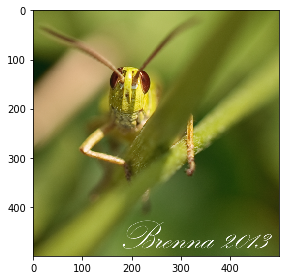

In [4]:
downsampled = rgb_downsample(color_image, kernel_size=2)
_ = io.imshow(downsampled)

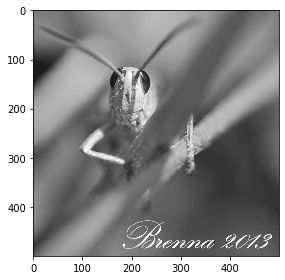

In [5]:
downsampled = nonlinear_downsample(grey_image, kernel_size=2, aggregate=np.max)
_ = io.imshow(downsampled)

# Upsampling

Use naive convolution interpolation to upsample the image by applying interpolation row-wise and then column-wise 

In [6]:
grey_image.shape

(1000, 1000)

In [7]:
%timeit

upsampled = image_interpolate(grey_image, kernel=kernels.linear_kernel, ratio=2)
upsampled.shape

(2000, 2000)

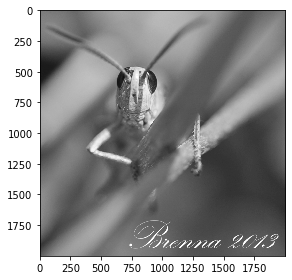

In [9]:
_ = io.imshow(upsampled)

RGB image can be interpolated the same way by applying ineterpolation to each channel

In [10]:
%timeit

color_upsampled_image = rgb_image_interpolate(color_image, kernel=kernels.linear_kernel, ratio=2)
color_upsampled_image.shape

(2000, 2000, 3)

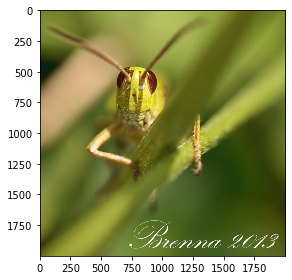

In [11]:
_ = io.imshow(color_upsampled_image)